# Imports #

In [1]:
import glob
import numpy as np
import scipy.ndimage
import cv2
import matplotlib.pyplot as plt

In [2]:
import sklearn
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.svm

In [3]:
import tracking
import features
import training

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.dpi'] = 50
plt.rcParams['figure.figsize'] = (18,9)

# Training #

In [5]:
# Full dataset
vehicles = np.stack(cv2.imread(f) for f in glob.glob('vehicles/*/*'))
non_vehicles = np.stack(cv2.imread(f) for f in glob.glob('non-vehicles/*/*'))

# # Small dataset
# vehicles = np.stack(cv2.imread(f) for f in glob.glob('vehicles_smallset/*/*')[:])
# non_vehicles = np.stack(cv2.imread(f) for f in glob.glob('non-vehicles_smallset/*/*')[:])

In [6]:
X = np.concatenate([    vehicles, #    vehicles[:, :, ::-1, :],
                    non_vehicles, #non_vehicles[:, :, ::-1, :],
                  ])
Y = np.concatenate([np.ones(len(vehicles)*1), np.zeros(len(non_vehicles)*1)])

In [7]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y)

In [8]:
feature_extractor = features.FeatureExtraction(hog_channel="ALL", hog_cells_per_step=4, cspace='HLS')
classifier = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler()),
    ("svm", sklearn.svm.SVC(C=1e3, kernel='linear')),
], memory='./sklearn-cache')

pipeline = sklearn.pipeline.Pipeline([
    ("features", feature_extractor),
    ('classifier', classifier),
], memory='./sklearn-cache')

In [9]:
%time pipeline.fit(X_train, Y_train);
;

/home/barghini/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/pipeline.py:222: UserWarning: Persisting input arguments took 0.60s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


CPU times: user 4min 56s, sys: 4.75 s, total: 5min 1s
Wall time: 5min 14s


''

In [10]:
res = {}
t = %timeit -n1 -r1 -q -o res['pred'] = pipeline.predict(X_test)
pred = res['pred']
accuracy = sklearn.metrics.accuracy_score(Y_test, pred)

In [11]:
print("Prediction time: {:.1f} ms/sample".format(t.best*1000/len(X_test)))
print("Accuracy:        {:.1%}".format(accuracy))

Prediction time: 15.7 ms/sample
Accuracy:        98.7%


In [12]:
training.store_model('test.P', None, pipeline, accuracy, {})
pipe2 = training.load_model('test.P')[0]

In [13]:
res = {}
t = %timeit -n1 -r1 -q -o res['pred'] = pipe2.predict(X_test)
pred2 = res['pred']
accuracy2 = sklearn.metrics.accuracy_score(Y_test, pred2)

In [14]:
print("Prediction time: {:.1f} ms/sample".format(t.best*1000/len(X_test)))
print("Accuracy:        {:.1%}".format(accuracy2))

Prediction time: 16.3 ms/sample
Accuracy:        98.7%


# Tracking #

In [64]:
_, feature_extractor, classifier = training.load_model('./test.P')
#_, feature_extractor, classifier = training.load_model('./model_local_all_classifier-svm-C=1000.0_classifier-svm-kernel=linear_features-cspace=HLS_features-hog_channels=ALL.P')

In [15]:
idx = slice(1, 4, 4)
tracker = tracking.CarTracker(yranges=[(350, 680), (350, 680), (350, 680), (350, 680)][idx],
                              scales=[0.5, 1, 1.5, 2][idx],
                              colors=[(192,  32,  32), ( 32, 192,  32),
                                      ( 32,  32, 192), ( 64, 224, 192)][idx],
                              hog_cells_per_step=4,
                              heat_threshold=1,
                              extract_features=feature_extractor.extract_features,
                              predict=classifier.predict,
                              merge_boxes=True,
                              expand_maximum=True,
                              alpha=0,
                              )

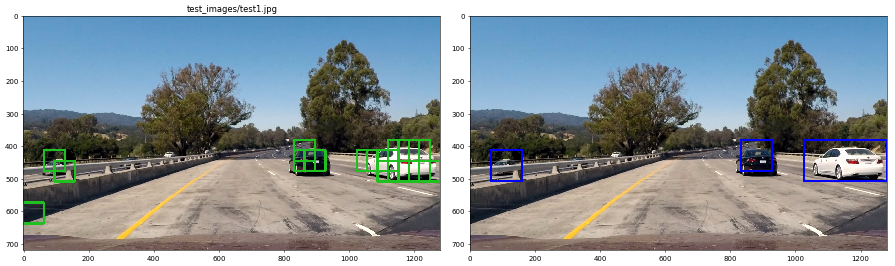

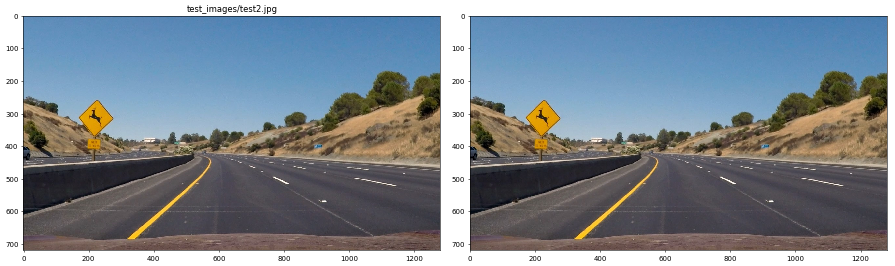

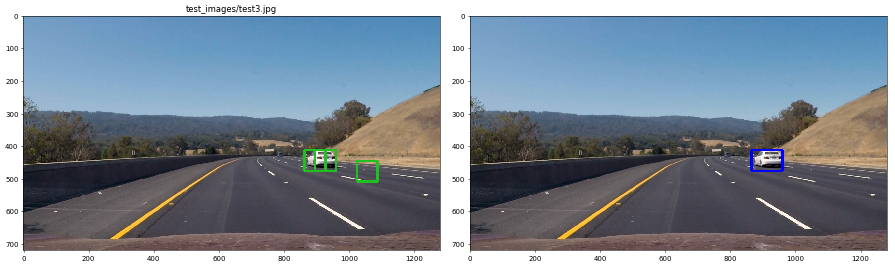

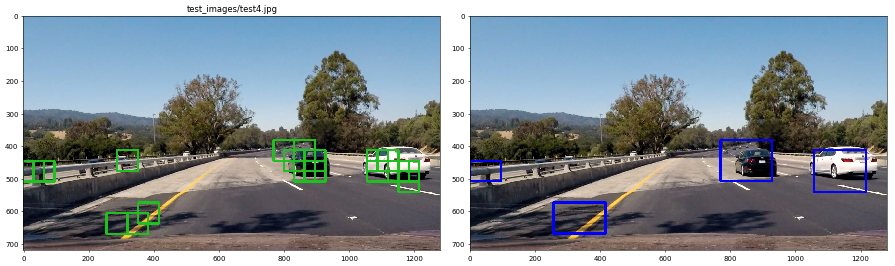

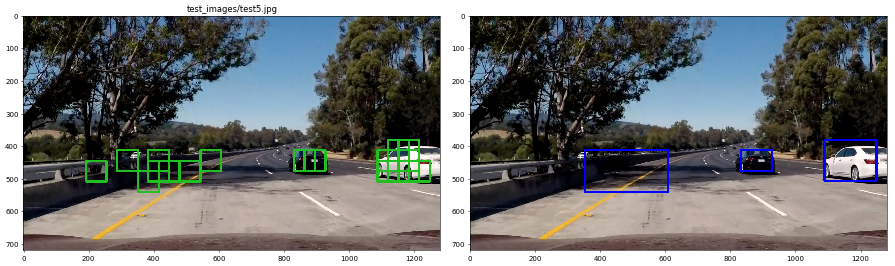

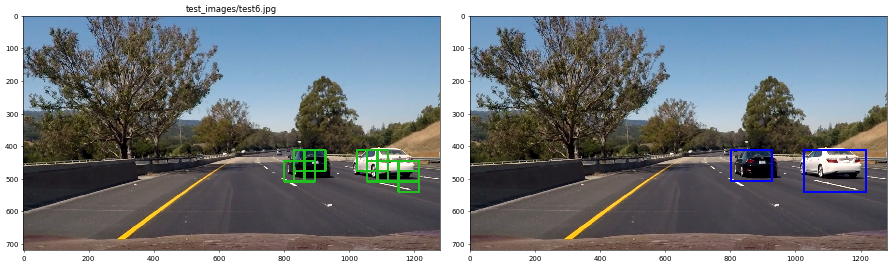

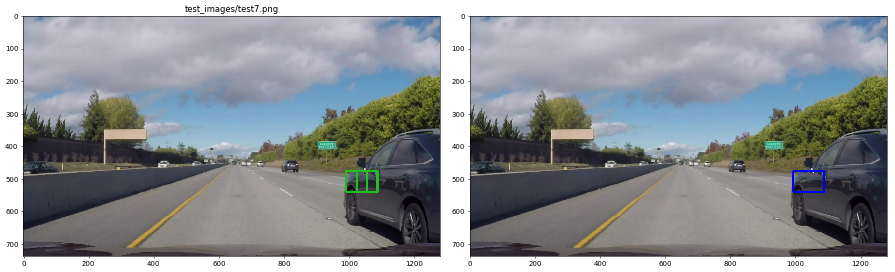

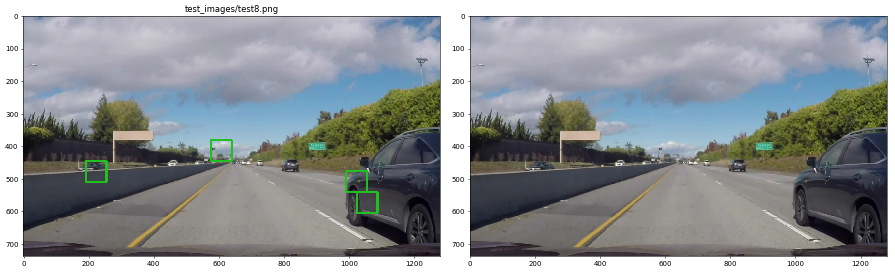

In [17]:
# %%prun -s tottime -l features|tracking|svm
for path in sorted(glob.glob('test_images/*'))[:]:
    image = cv2.imread(path)[..., ::-1]
    result, unmerged = tracker(image, return_unmerged=True)
    
    plt.subplot(121)
    plt.imshow(unmerged)
    plt.title(path)
    
    plt.subplot(122)
    plt.imshow(result)
    
    plt.tight_layout()
    plt.show()

In [123]:
from moviepy.editor import VideoFileClip
tracker.alpha = 0.25
tracker.heatmap = None
clip = VideoFileClip('project_video.mp4')#.subclip(6, 10)
output = clip.fl_image(tracker)
output.write_videofile('test.mp4', audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|█████████▉| 1260/1261 [2:24:53<00:06,  6.98s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 



<video controls src="test.mp4" width="100%"/>

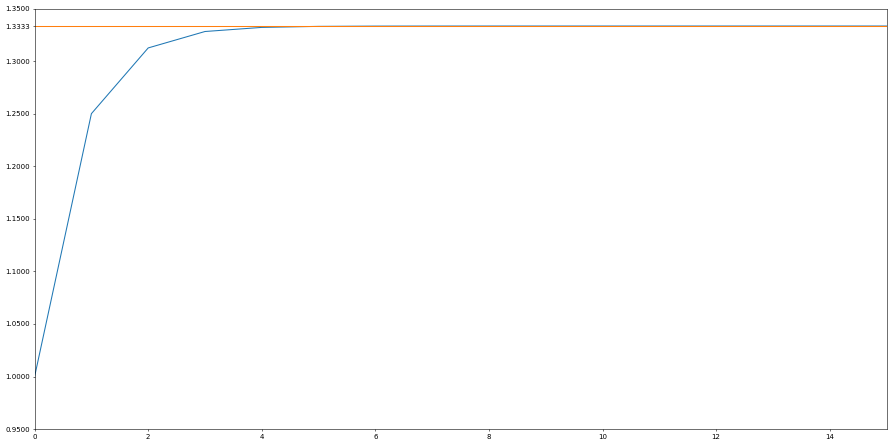

In [121]:
alpha = 0.25
h = 0
f = 1

x = np.linspace(0, 15, 16)
y = h * alpha ** x + f*(alpha**(x+1) - 1) / (alpha - 1)
l = f / (1 - alpha)
plt.plot(x, y)
plt.axhline(l, 0, 1, c='C1')
plt.yticks(plt.yticks()[0].tolist() + [l])
plt.xlim(x.min(), x.max())
plt.tight_layout()

alpha = 0.5

h = np.arange(1, 16)
l = np.log(1/h) / np.log(alpha)
plt.plot(h, l)
plt.xlim(l.min(), l.max())
plt.xlim(h.min(), h.max())
plt.tight_layout()

15.243462198


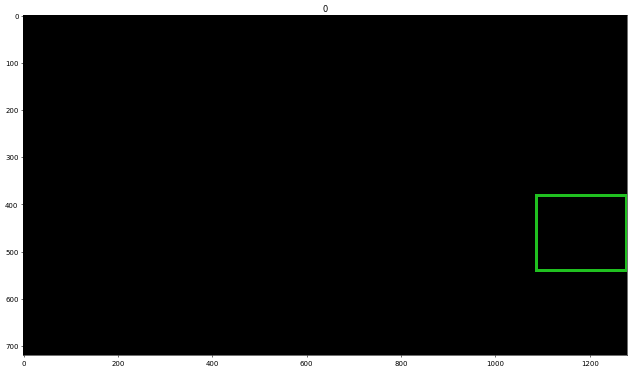

13.7191159782


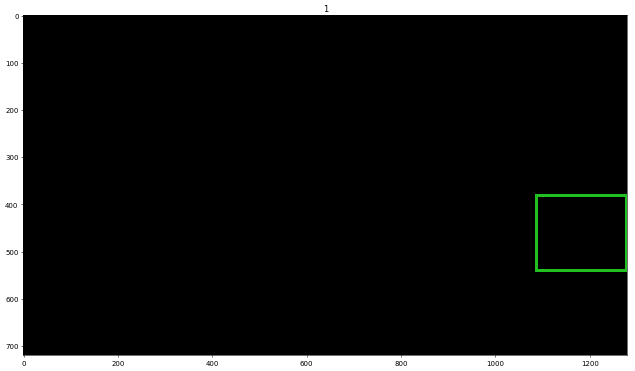

12.3472043804


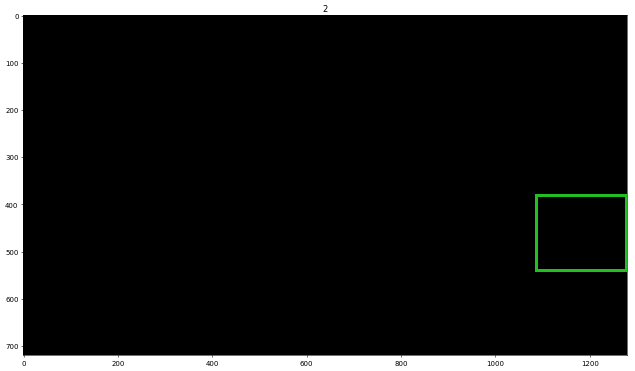

11.1124839423


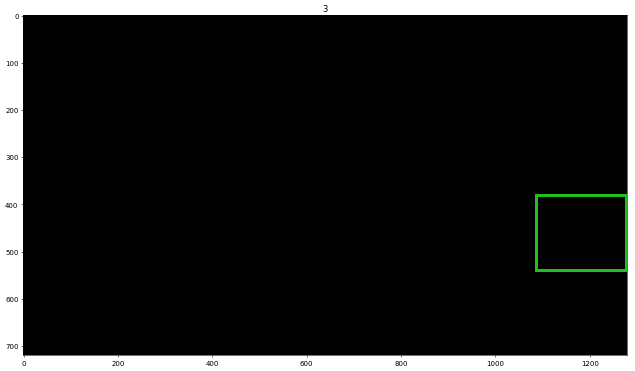

10.0012355481


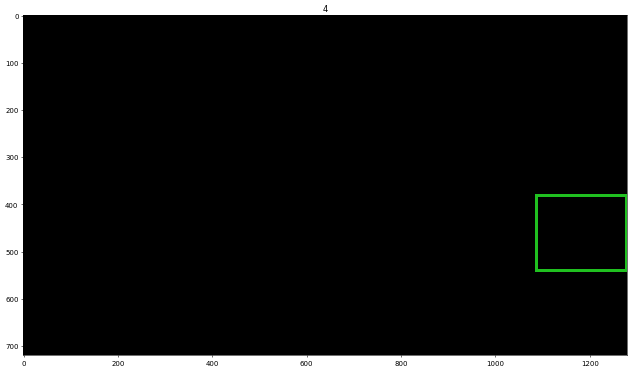

9.0011119933


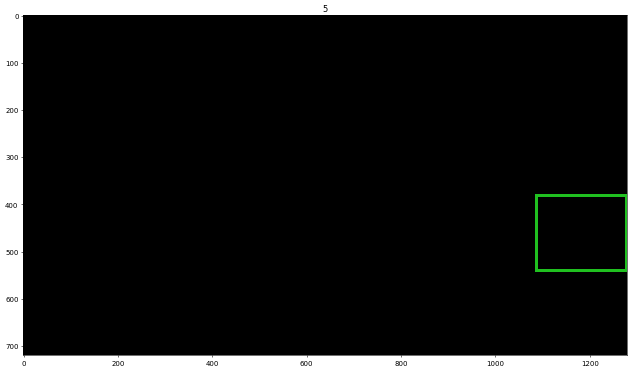

8.10100079397


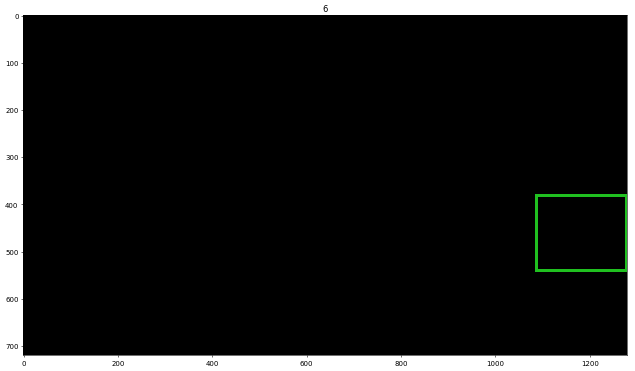

7.29090071457


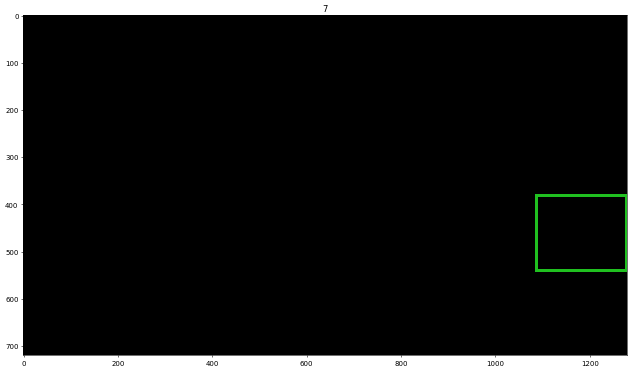

6.56181064311


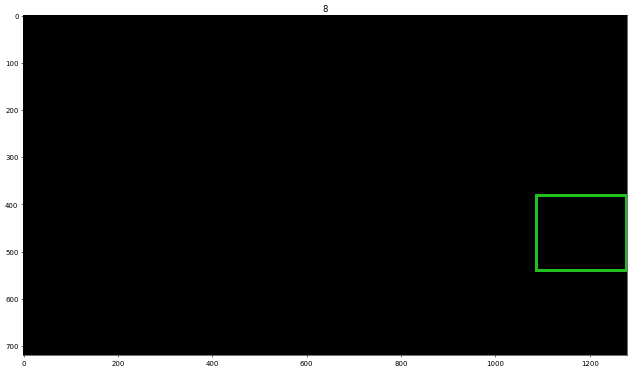

5.9056295788


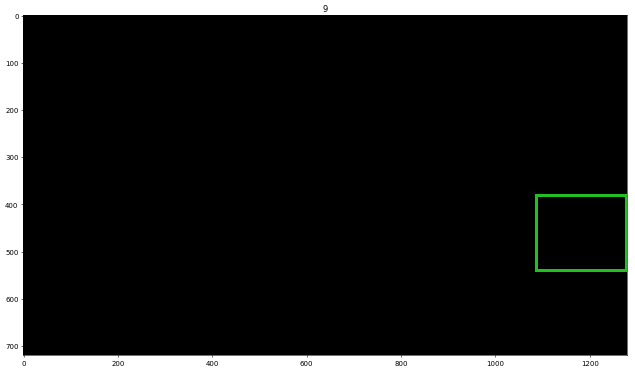

5.31506662092


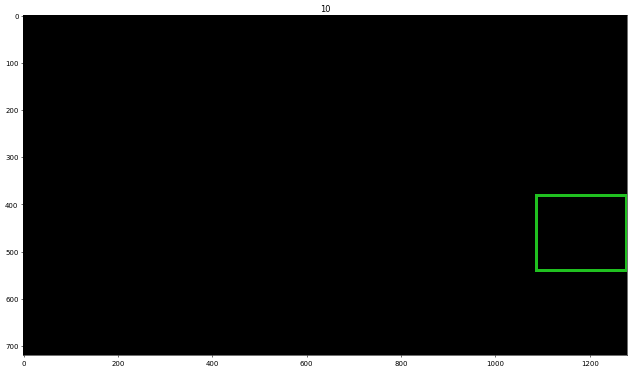

4.78355995883


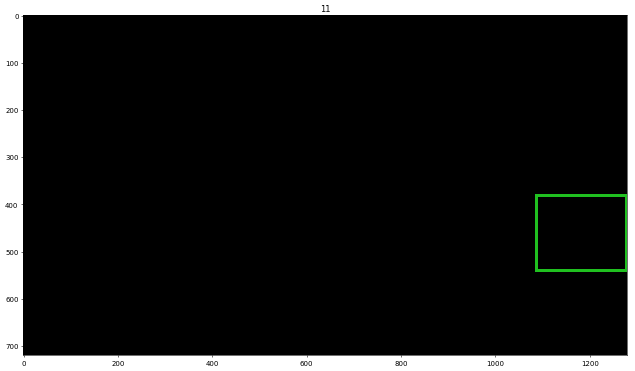

4.30520396295


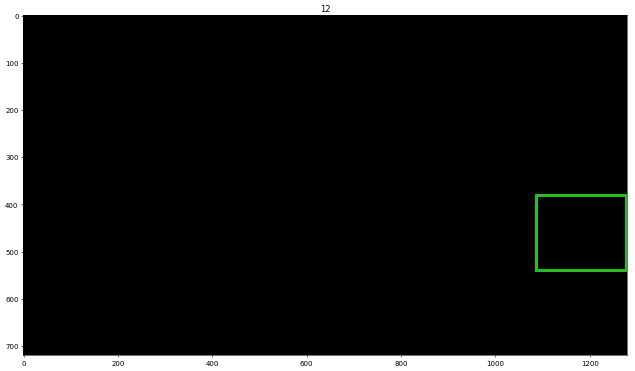

3.87468356665


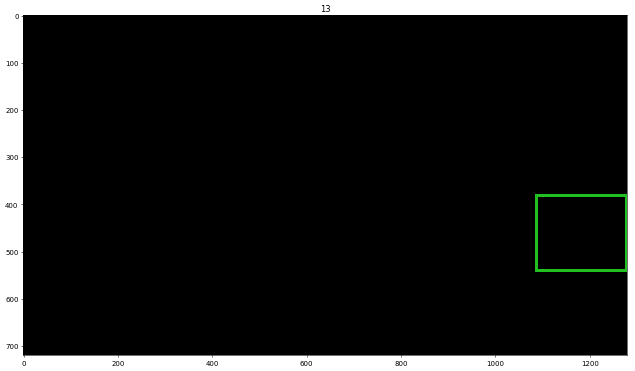

3.48721520999


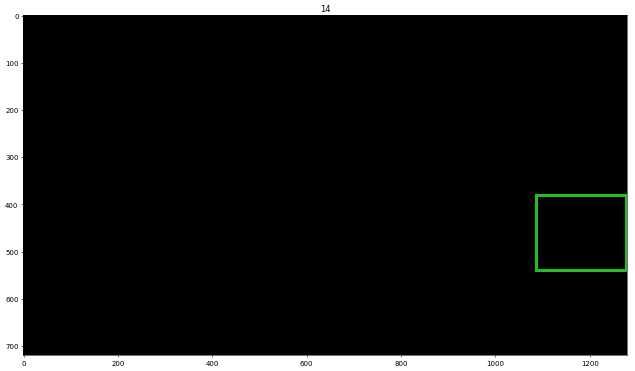

KeyboardInterrupt: 

In [26]:
#tracker.heatmap = None\
for i in range(25):
    frame = clip.get_frame(7 + i/clip.fps)
    plt.imshow(tracker(frame*0))
    plt.title(str(i))
    plt.show()

# %%prun -s tottime -l features|lesson|svm
idx = slice(1, 4, 4)
for path in sorted(glob.glob('test_images/*'))[:1]:
    plt.figure()
    image = cv2.imread(path)
    bboxes = tracking.find_cars(image,
                                yranges=[(350, 680), (350, 680), (350, 680), (350, 680)][idx],
                                scales=[0.5, 1, 1.5, 2][idx],
                                hog_cells_per_step=4,
                                extract_features=feature_extractor.extract_features,
                                predict=classifier.predict,
                               )
    merged_boxes = tracking.merge_boxes(image, bboxes, heat_threshold=1, expand_maximum=True)[0]
    result = tracking.draw_boxes(image, bboxes,
                                 colors=[(192,  32,  32), ( 32, 192,  32),
                                         ( 32,  32, 192), ( 64, 224, 192)][idx])
    plt.subplot(121)
    plt.imshow(result[..., ::-1])
    plt.title(path)
    plt.subplot(122)
    plt.imshow(tracking.draw_boxes(image, merged_boxes)[..., ::-1])
    plt.tight_layout()
    plt.show()